# Branching/Recombination Gaussian Processes

In this Jupyter notebook we introduce Branching/Recombination Gaussian Processes. In section 1 we demonstrate how B/RGPs can be constructed using change-point kernels (Lloyd et al., 20XX) within a hierarchical Gaussian Process framework (Hensmann et al., 2012). In section 2 we use B/RGPs to fit simulated datasets using the $\texttt{gpml}$ toolbox. Finally, in section 3, we demonstrate the use of B/RGPs on real data taken from Lewis et al. (2015), which contains 3 Arabidopsis times series following infection with *Pseudomonas syringae*.

For this notebook a basic working knowledge of Gaussian Processes is assumed. A good introduction to GPs can be found in Rasmussen and Williams (200X).

### Section 1: Introducing Branching/Recombination GPs

Before we begin we first need to set the file path to ensure we can call any function from our current directory. We also reset the random number generator to ensure repeatability.

In [1]:
rng(1)
addpath(genpath('../../'))
warning off all

We will now construct a simple Branching Gaussian Process using changepoint kernels from Lloyd et al. (20XX) within a hierarchical Gaussian Process framework (Hensman et al., 20XX). We first consider a base process:

$f_1(x) \sim \mathcal{GP}(\mu(x),\mathcal{C}_1(x,x^\prime)).$

A subsequent branch can be defined via:

$f_2(x) \sim \mathcal{GP}(f_1(x),\mbox{CP}(0(x,x^\prime),\mathcal{C}_2(x,x^\prime))),$

where $\mathcal{C}(\cdot,\cdot)$ represents an arbitrary covariance function, $\mbox{CP}(0,\cdot)$ denotes a change-point kernel, that smooths from a zero-kernel and covariance function $\mathcal{C}_2(\cdot,\cdot)$. 

Below we generate samples from such a process. In particular we fix the base and branch kernels to be squared exponentials, $\mathcal{C}_1(x,x^\prime) = \mathcal{C}_2(x,x^\prime) = \mbox{SE}(x,x^\prime)$, and generate samples from the function at uniformly incremented positions, $\mathbf{x}$.

In [87]:
x = linspace(0,10,100); %Uniformly increments over x.
covN1 = {@covChangePointMultiD, {1, @covZero, @covSEiso}}; %Specify the changepoint covariance

SE_HP1 = [1,3];
SE_HP2 = [0.2,3];
Changepoint_HP = [3,0.5];

K1   = covSEiso(SE_HP1,x'); %Base kernel (in this case a SE)
K2   = feval(covN1{:}, [Changepoint_HP,SE_HP2], x'); %The branch process

Kall = [K1,K1;K1,K1+K2]; %Construct the covariance matrix at x for both processes

y=real(gsamp(zeros(1,200),Kall,10)); %Generate a sample from the process

We can now plot the covariance matrix and samples:

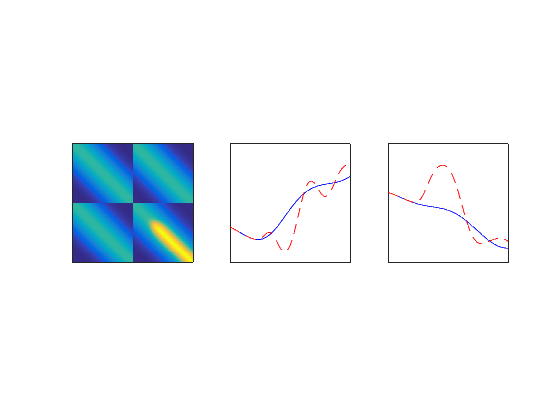

In [89]:
subplot(1,3,1); imagesc(Kall)
set(gca,'XTick',[],'YTick',[])
axis square

hold on
subplot(1,3,3);plot(x,real(y(1,1:100))','b-'),hold on, plot(x,real(y(1,101:200))','r--'),set(gca,'XTick',[],'YTick',[]),axis square%,plot(x,real(y(1,201:300))','g')
subplot(1,3,2);plot(x,real(y(2,1:100))','b-'),hold on, plot(x,real(y(2,101:200))','r--'),set(gca,'XTick',[],'YTick',[]),axis square%,plot(x,real(y(2,201:300))','g')


We can see from the samples that the processes diverge around the specified changepoint time. Let's try some more complicated examples. Below we specifiy a periodic process branching from a smooth underlying process (square exponential).

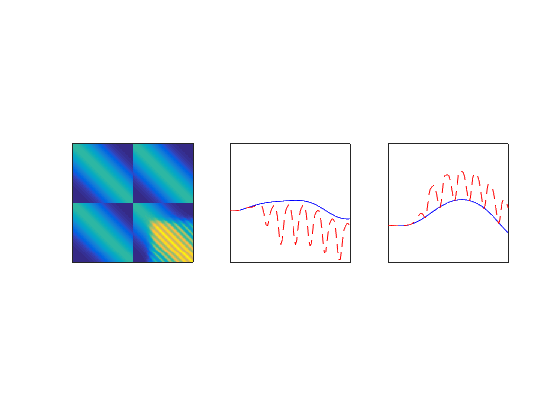

In [90]:
covN1 = {@covChangePointMultiD, {1, @covZero, @covPeriodic}};

%Params
SE_HP = [1,3];
Per_HP = [0.5,0.2,3];
Changepoint_HP = [3,0.5];

K1    = covSEiso([SE_HP],x');
K2    = feval(covN1{:}, [Changepoint_HP,Per_HP], x');
Kall  = [K1,K1;K1,K1+K2];

y     = real(gsamp(zeros(1,200),Kall,10));

subplot(1,3,1); imagesc(Kall),set(gca,'XTick',[],'YTick',[]),axis square
subplot(1,3,2);plot(x,real(y(1,1:100))','b'),hold on, plot(x,real(y(1,101:200))','r--'),set(gca,'XTick',[],'YTick',[]),axis square%,plot(x,real(y(1,201:300))','g')
subplot(1,3,3);plot(x,real(y(2,1:100))','b'),hold on, plot(x,real(y(2,101:200))','r--'),set(gca,'XTick',[],'YTick',[]),axis square%,plot(x,real(y(2,201:300))','g')


We can very easily specify a 3-component branching process:

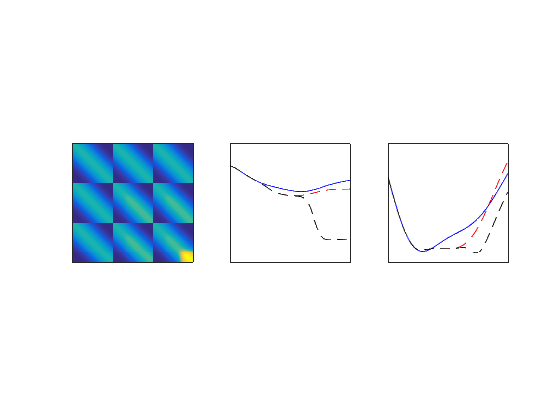

In [92]:
covN1 = {@covChangePointMultiD, {1, @covZero, @covSEiso}};

K1   = covSEiso([1,3],x');
K2   = feval(covN1{:}, [3,0.5,1,2], x');
K3   = feval(covN1{:}, [7,0.5,3,3], x');
Kall = [K1,K1,K1;
        K1,K1+K2,K1+K2;
        K1,K1+K2,K1+K2+K3];
y=real(gsamp(zeros(1,300),Kall,10));

subplot(1,3,1); imagesc(Kall),set(gca,'XTick',[],'YTick',[]),axis square
subplot(1,3,2);plot(x,real(y(1,1:100))','b'),hold on, plot(x,real(y(1,101:200))','r--'),plot(x,real(y(1,201:300))','k--'),set(gca,'XTick',[],'YTick',[]),axis square
subplot(1,3,3);plot(x,real(y(2,1:100))','b'),hold on, plot(x,real(y(2,101:200))','r--'),plot(x,real(y(2,201:300))','k--'),set(gca,'XTick',[],'YTick',[]),axis square

In much the same way we specified a branching process, we can also specify a recombination process. The only difference here is that the changepoint smooths to a zero-kernel after the changepoint time rather than from a zero-kernel. For a two-component recombination process we have:

$f_1(x) \sim \mathcal{GP}(0,\mathcal{C}(x,x^\prime)),$

and a branch process:

$f_2(x) \sim \mathcal{GP}(f(x),\mbox{CP}(\mathcal{C}(x,x^\prime),0)).$

Below we plot examples of recombination processes:

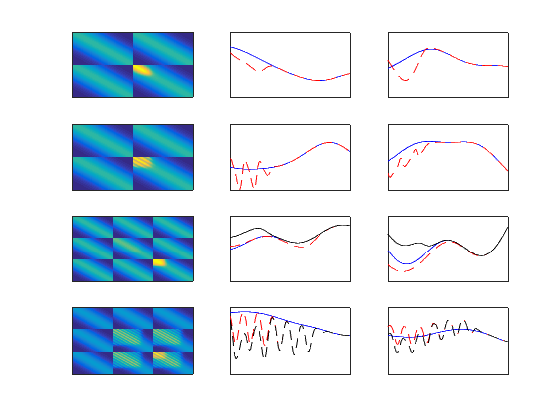

In [93]:
covN1 = {@covChangePointMultiD, {1, @covSEiso,@covZero}};
K1    = covSEiso([1,3],x');
K2    = feval(covN1{:}, [3,0.5,0.2,3], x');
Kall  = [K1,K1;K1,K1+K2];
y     = real(gsamp(zeros(1,200),Kall,10));


subplot(4,3,3);plot(x,real(y(1,1:100))','b'),hold on, plot(x,real(y(1,101:200))','r--'),set(gca,'XTick',[],'YTick',[])%,plot(x,real(y(1,201:300))','g')
subplot(4,3,2);plot(x,real(y(2,1:100))','b'),hold on, plot(x,real(y(2,101:200))','r--'),set(gca,'XTick',[],'YTick',[])%,plot(x,real(y(2,201:300))','g')
subplot(4,3,1); imagesc(Kall),,set(gca,'XTick',[],'YTick',[])

covN1 = {@covChangePointMultiD, {1, @covPeriodic, @covZero}};
K1    = covSEiso([1,3],x');
K2    = feval(covN1{:}, [3,0.5,0.5,0.2,3], x');
Kall  = [K1,K1;K1,K1+K2];
y     = real(gsamp(zeros(1,200),Kall,10));
subplot(4,3,6);plot(x,real(y(1,1:100))','b'),hold on, plot(x,real(y(1,101:200))','r--'),set(gca,'XTick',[],'YTick',[])%,plot(x,real(y(1,201:300))','g')
subplot(4,3,5);plot(x,real(y(2,1:100))','b'),hold on, plot(x,real(y(2,101:200))','r--'),set(gca,'XTick',[],'YTick',[])%,plot(x,real(y(2,201:300))','g')
subplot(4,3,4); imagesc(Kall),set(gca,'XTick',[],'YTick',[])

covN1 = {@covChangePointMultiD, {1, @covSEiso, @covZero}};
K1   = covSEiso([1,3],x');
K2   = feval(covN1{:}, [7,0.5,1,2], x');
K3   = feval(covN1{:}, [3,0.5,3,3], x');
Kall = [K1,K1,K1;K1,K1+K2,K1;K1,K1,K1+K3];
y=real(gsamp(zeros(1,300),Kall,10));

subplot(4,3,9);plot(x,real(y(1,1:100))','b'),hold on, plot(x,real(y(1,101:200))','r--'),,plot(x,real(y(1,201:300))','k-'),set(gca,'XTick',[],'YTick',[])
subplot(4,3,8);plot(x,real(y(2,1:100))','b'),hold on, plot(x,real(y(2,101:200))','r--'),plot(x,real(y(2,201:300))','k-'),set(gca,'XTick',[],'YTick',[])
subplot(4,3,7); imagesc(Kall),,set(gca,'XTick',[],'YTick',[])

covN1 = {@covChangePointMultiD, {1, @covPeriodic,@covZero}};
covN2 = {@covChangePointMultiD, {1, @covPeriodic,@covZero}};

K1   = covSEiso([1,3],x');
K2   = feval(covN1{:}, [7,0.5,0.5,0.2,3], x');
K3   = feval(covN1{:}, [3,0.5,0.5,0.6,3], x');
Kall = [K1,K1,   K1;
        K1,K1+K2,K1+K2;
        K1,K1+K2,K1+K2+K3];
y    = real(gsamp(zeros(1,300),Kall,10));
subplot(4,3,12);plot(x,real(y(1,1:100))','b'),hold on, plot(x,real(y(1,101:200))','r--'),plot(x,real(y(1,201:300))','k--'),set(gca,'XTick',[],'YTick',[])
subplot(4,3,11);plot(x,real(y(2,1:100))','b'),hold on, plot(x,real(y(2,101:200))','r--'),plot(x,real(y(2,201:300))','k--'),set(gca,'XTick',[],'YTick',[])
subplot(4,3,10); imagesc(Kall),set(gca,'XTick',[],'YTick',[])


Finally, we can combine branching and recombination to produce almost arbitrary behaviour.

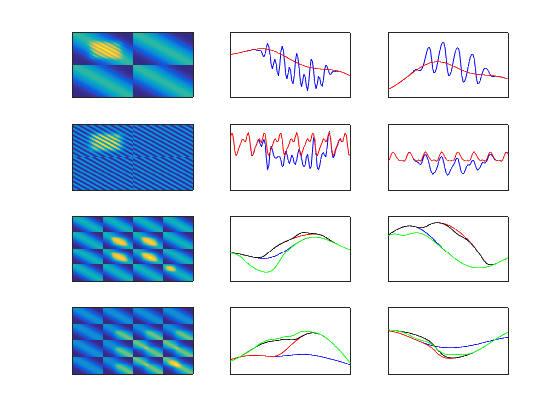

In [7]:
covN2 = {@covChangePointMultiD, {1, {@covChangePointMultiD, {1, @covZero, @covPeriodic}}, @covZero}};

K2   = feval(covN2{:}, [8,0.5,3,0.5,0.5,0.2,3], x');
Kall = [K2+K1,K1;K1,K1];

y    = real(gsamp(zeros(1,200),Kall,10));
subplot(4,3,3);plot(x,real(y(1,1:100))','b'),hold on, plot(x,real(y(1,101:200))','r'),set(gca,'XTick',[],'YTick',[])
subplot(4,3,2);plot(x,real(y(2,1:100))','b'),hold on, plot(x,real(y(2,101:200))','r'),set(gca,'XTick',[],'YTick',[])
subplot(4,3,1); imagesc(Kall),set(gca,'XTick',[],'YTick',[])

K1a  = covPeriodic([0.5,0.3,3],x');
K2   = feval(covN2{:}, [8,0.5,3,0.5,0.5,0.2,3], x');
Kall = [K2+K1a,K1a;K1a,K1a];
y    = real(gsamp(zeros(1,200),Kall,10));
subplot(4,3,6);plot(x,real(y(1,1:100))','b'),hold on, plot(x,real(y(1,101:200))','r'),set(gca,'XTick',[],'YTick',[])
subplot(4,3,5);plot(x,real(y(2,1:100))','b'),hold on, plot(x,real(y(2,101:200))','r'),set(gca,'XTick',[],'YTick',[])
subplot(4,3,4); imagesc(Kall),set(gca,'XTick',[],'YTick',[])

covN2 = {@covChangePointMultiD, {1, {@covChangePointMultiD, {1, @covZero, @covSEiso}}, @covZero}};

K2   = feval(covN2{:}, [8,0.5,3,0.5,1,3], x');
K3   = feval(covN2{:}, [6,0.5,5.5,0.5,1,3], x');
K4   = feval(covN2{:}, [4,0.5,1,0.5,1,3], x');
Kall = [K1,K1,   K1,      K1;
        K1,K1+K2,K1+K2,   K1;
        K1,K1+K2,K1+K2+K3,K1;
        K1,K1   ,K1,      K1+K4];
        
y=real(gsamp(zeros(1,400),Kall,10));
subplot(4,3,9);plot(x,y(1,1:100)','b'),hold on, plot(x,y(1,101:200)','r'),plot(x,y(1,201:300)','k'),plot(x,y(1,301:400)','g'),set(gca,'XTick',[],'YTick',[])
subplot(4,3,8);plot(x,y(3,1:100)','b'),hold on, plot(x,y(3,101:200)','r'),plot(x,y(3,201:300)','k'),plot(x,y(3,301:400)','g'),set(gca,'XTick',[],'YTick',[])
subplot(4,3,7); imagesc(Kall),set(gca,'XTick',[],'YTick',[])

covN1 = {@covChangePointMultiD, {1, @covZero, @covSEiso}};
covN2 = {@covChangePointMultiD, {1, @covSEiso, @covZero}};
covN3 = {@covChangePointMultiD, {1, {@covChangePointMultiD, {1, @covZero, @covSEiso}}, @covZero}};

K2   = feval(covN1{:}, [4,0.5,1,3], x');
K3   = feval(covN2{:}, [5,0.5,1,3], x');
K4   = feval(covN3{:}, [6,0.5,2,0.5,1,3], x');

Kall = [K1,K1,   K1,      K1;
        K1,K1+K2,K1+K2,   K1+K2;
        K1,K1+K2,K1+K2+K3,K1+K2+K3;
        K1,K1+K2   ,K1+K2+K3,      K1+K2+K3+K4];
y    = real(gsamp(zeros(1,400),Kall,10));
subplot(4,3,12);plot(x,y(1,1:100)','b'),hold on, plot(x,y(1,101:200)','r'),plot(x,y(1,201:300)','k'),plot(x,y(1,301:400)','g'),set(gca,'XTick',[],'YTick',[])
subplot(4,3,11);plot(x,y(3,1:100)','b'),hold on, plot(x,y(3,101:200)','r'),plot(x,y(3,201:300)','k'),plot(x,y(3,301:400)','g'),set(gca,'XTick',[],'YTick',[])
subplot(4,3,10); imagesc(Kall),set(gca,'XTick',[],'YTick',[])


## Section 2: Fitting Branching Processes to Labelled Data

In the previous section we introduced how to construct branching/recombination processes. In this section we demonstrate how we can fit a B/RGP to labelled data. First we generate a simple branching/recombination process:

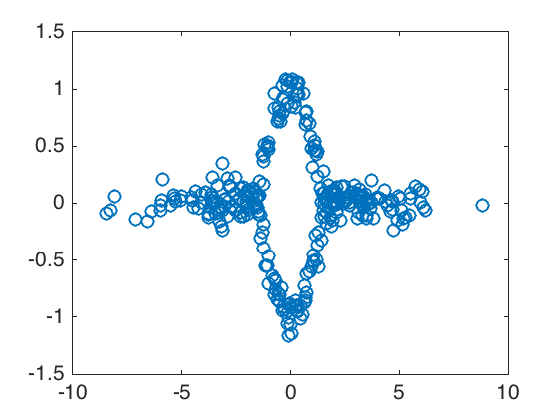

In [8]:
clear x y z 
xreal = linspace(-8,8,3000);
yreal1 = zeros(1,3000);
yreal1(find(xreal>=-pi/2 & xreal<=pi/2)) = cos(xreal(find(xreal>=-pi/2 & xreal<=pi/2)));
yreal2 = zeros(1,3000);
yreal2(find(xreal>=-pi/2 & xreal<=pi/2)) = -cos(xreal(find(xreal>=-pi/2 & xreal<=pi/2)));
count = 0;
x = randn(300,1)*3;
for i = 1:length(x);
if x(i)<-pi/2
    y(i) = 0;
    if rand(1,1)<0.5
    z(i) = 1;
    else
    z(i) = 2;
    end
elseif x(i)>pi/2
y(i) = 0;
if rand(1,1)<0.5
z(i) = 1;
else
z(i) = 2;
end
else
if rand(1)>0.5
y(i) = cos(x(i));
z(i) = 1;
else
y(i) = -cos(x(i));
z(i) = 2;
end
end
end
y = y+randn(1,300)*0.1;
X = [x,z'];

%Order data
[Y,I] = sortrows(X,[2,1]);
z = z(I);
X = X(I,:);
Y = y';
Y = Y(I);

plot(x,y,'o')

Xstar = [linspace(-8,8,3000)',ones(3000,1);linspace(-8,8,3000)',2*ones(3000,1)];

The input data is 2 dimensional labelled data, $X = \{x,z\}$, where $x$ represents a real valued random variable (for most of our applications we will assume this to be time), and $z \in [0,1]$ represents an discrete variable indicating branch memebership. Let's first optimised and fit individual GPs to each branch seperately:

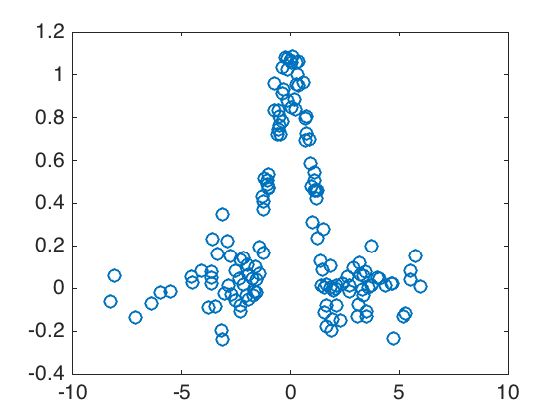

In [9]:
X1 = X(X(:,2)==1,1); %Here we get only the data for branch 1.
Y1 = Y(X(:,2)==1,1);
plot(X1,Y1,'o')

In [10]:
u = log(rand(6,1));
hyp.cov = u(1:2);
hyp.mean = mean(X(find(X(:,2)==1),1));
hyp.lik = log(.2);
hyp_pN      = feval(@minimize, hyp, @gp, -30000, @infExact, 'meanConst','covSEiso','likGauss',X1,Y1);

Now we can make predictions:

In [11]:
[ymu1 ys21 fmu1 fs21   ] = gp(hyp_pN, 'infExact', 'meanConst', 'covSEiso', 'likGauss', X1, Y1, unique(Xstar(:,1)));

Finally calculate the likelihood

In [12]:
[L1 dL1   ] = gp(hyp_pN, 'infExact', 'meanConst', 'covSEiso', 'likGauss', X1, Y1);

Now let's do the same again for branch 2.

In [13]:
X2 = X(X(:,2)==2,1); %X for branch 2
Y2 = Y(X(:,2)==2,1);
hyp.cov = u(3:4);
hyp.mean = mean(X(find(X(:,2)==2),1));
hyp.lik = log(.2);
hyp_pN      = feval(@minimize, hyp, @gp, -30000, @infExact, 'meanConst','covSEiso','likGauss',X2,Y2);
[ymu2 ys22 fmu2 fs22   ] = gp(hyp_pN, 'infExact', 'meanConst', 'covSEiso', 'likGauss', X2, Y2, unique(Xstar(:,1)));
[L2 dL2   ] = gp(hyp_pN, 'infExact', 'meanConst', 'covSEiso', 'likGauss', X2, Y2);

Finally let's plot the results. 

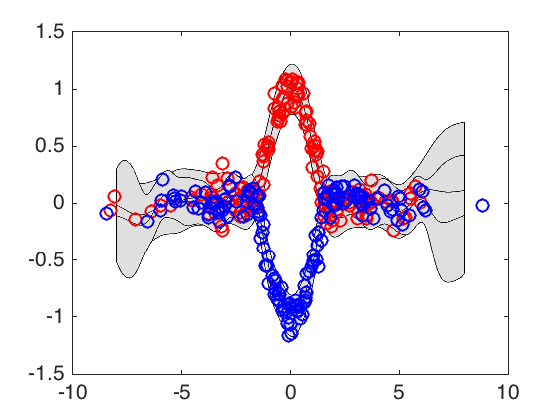

In [14]:
 xpredloc = Xstar(1:3000,1);
 f = [fmu1(1:3000)+2*sqrt(ys21(1:3000)); flipdim(fmu1(1:3000)-2*sqrt(ys21(1:3000)),1)];
 fill([xpredloc; flipdim(xpredloc,1)], f, [7 7 7]/8);
 hold on
 f = [fmu2(1:end)+2*sqrt(ys22(1:end)); flipdim(fmu2(1:end)-2*sqrt(ys22(1:end)),1)];
 fill([xpredloc; flipdim(xpredloc,1)], f, [7 7 7]/8);
 plot(Xstar(1:3000,1),fmu1(1:3000),'k-'),hold on
 plot(Xstar(1:3000,1),fmu2(1:end),'k-')
 plot(X(z==1,1),Y(z==1),'ro'),
 plot(X(z==2,1),Y(z==2),'bo')

Okay, not bad. But not particularly great. We can do better with a branching/recombinaiton GPs.

In [15]:
u = log(rand(6,1));
hyp.cov = [4;0.5;0.5;-4;0.5;0.5;u];
hyp.mean = mean(X(:,1));
hyp.lik = log(.2);

In [16]:
hyp_pN      = feval(@minimize, hyp, @gp, -300, 'infExact', 'meanConst','covBranchingRecombinationProcess_2A',@likGauss,X,Y);

In [17]:
[ymu3 ys3 fmu3 fs3   ] = gp(hyp_pN, 'infExact', 'meanConst', 'covBranchingRecombinationProcess_2A', @likGauss, X, Y, Xstar);
[L3 dL3   ] = gp(hyp_pN, 'infExact', 'meanConst', 'covBranchingRecombinationProcess_2A', @likGauss, X, Y);

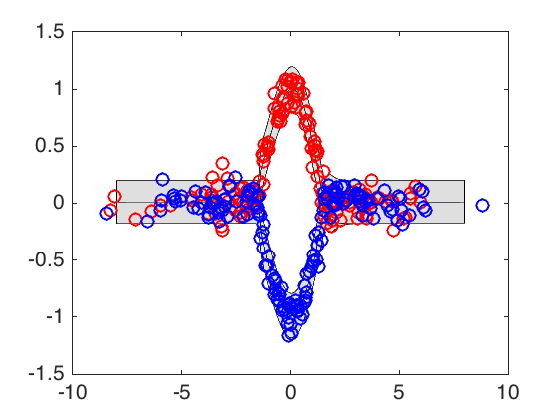

In [18]:
xpredloc = Xstar(1:3000,1);
f = [fmu3(1:3000)+2*sqrt(ys3(1:3000)); flipdim(fmu3(1:3000)-2*sqrt(ys3(1:3000)),1)];
fill([xpredloc; flipdim(xpredloc,1)], f, [7 7 7]/8);
hold on
f = [fmu3(3000+1:end)+2*sqrt(ys3(3000+1:end)); flipdim(fmu3(3000+1:end)-2*sqrt(ys3(3000+1:end)),1)];
fill([xpredloc; flipdim(xpredloc,1)], f, [7 7 7]/8);
plot(Xstar(1:3000,1),fmu3(1:3000),'k-')
plot(Xstar(3001:end,1),fmu3(3001:end),'k-')
plot(X(z==1,1),Y(z==1),'ro'),
plot(X(z==2,1),Y(z==2),'bo')

Okay, that's more like it. The fit appears to be significantly better than than the individual fits using independent GPs. For a laugh we can also compare these models to a single joint Gaussian Process applied to the union of time series. 

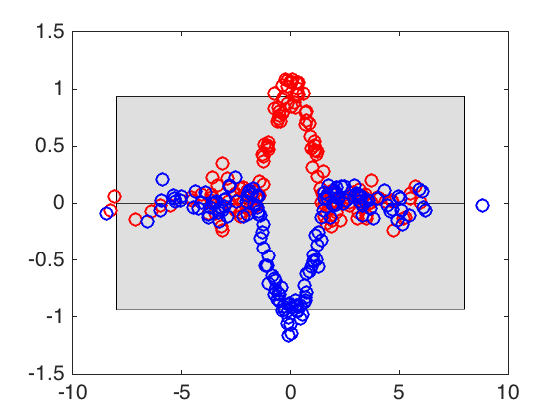

In [19]:
hyp.cov = u(1:2);
hyp.mean = mean(X(:,1));
hyp.lik = log(.2);
hyp_pN      = feval(@minimize, hyp, @gp, -30000, @infExact, 'meanConst','covSEiso','likGauss',X(:,1),Y);
[ymu4 ys24 fmu4 fs24   ] = gp(hyp_pN, 'infExact', 'meanConst', 'covSEiso', 'likGauss', X(:,1), Y, unique(Xstar(:,1)));
[L4 dL4   ] = gp(hyp_pN, 'infExact', 'meanConst', 'covSEiso', 'likGauss', X(:,1), Y);
xpredloc = Xstar(1:3000,1);
f = [fmu4(1:3000)+2*sqrt(ys24(1:3000)); flipdim(fmu4(1:3000)-2*sqrt(ys24(1:3000)),1)]; 
fill([xpredloc; flipdim(xpredloc,1)], f, [7 7 7]/8);
hold on
plot(Xstar(1:3000,1),fmu4(1:3000),'k-')
plot(X(z==1,1),Y(z==1),'ro'),
plot(X(z==2,1),Y(z==2),'bo')

Well, that's pretty rubbish! By eye, then, B/RGPs appear to fit the data better than independent GPs and joint GPs. To make sure it's *really* doing better, lets evaluate the marginal likelihoods of the various models.

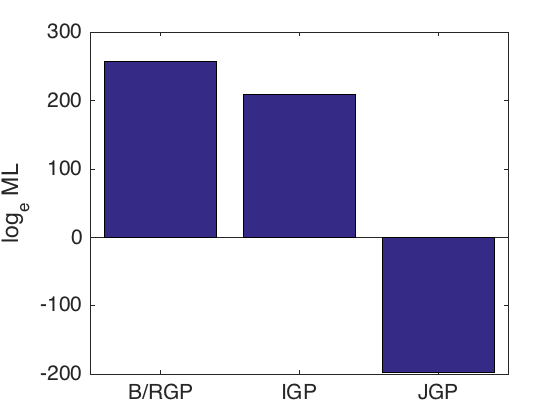

In [20]:
bar(-[L3,L1+L2,L4]),set(gca,'XTick',1:1:3,'XTickLabel',{'B/RGP','IGP','JGP'}),ylabel('log_e ML')

The marginal likelihood for Branching/Recombination GPs is much larger than for independent GPs, and both of the models are significantly greater than the joint GP

### Section 3: Fitting B/RGPs to Arabdopsis Expression Data

In the previous section we have seen that B/RGPs do a pretty good job at fitting simulated data, but how is this of practical usef? 

One application is to identify the nature and timing of branching in collections of time series datasets. For example, when we have 3 or more time series, we could feasibly have a variety of branching behaviour. We could therefore identify *how* the time series branch processes *when* the time series branch. In this sense we can think of this as a generalisation of the GPTwoSample of Stegle et al. (2010).

Let's look at one such time series, taken from Lewis et al. (2015). This datasets contains time series of *Arabidopsis thaliana* transcript levels over a $17.5$ hour time course in $3$ conditions: (i) a control time-series; (ii) infection with a harmless strain of Pseudomonas (*P. syringae DC3000hrpA*); (iii) infection with the virulent *P. syringae DC3000*. 

In the snippet of code below we load in the data, and plot an example expression profiles:

In [21]:
D1 = importdata('../Pa13-Combo2.txt');

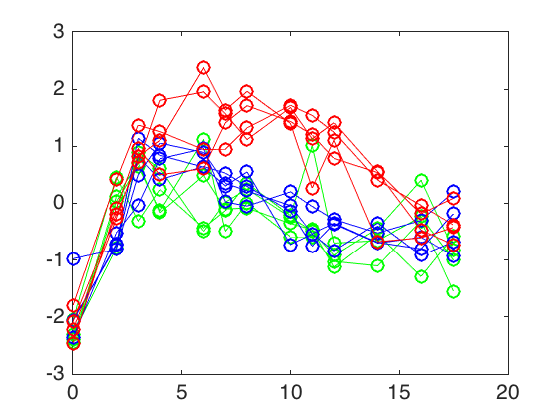

In [22]:
gene_index = 1;
tt         = [0,2,3,4,6,7,8,10,11,12,14,16,17.5];
expression_profile = reshape(D1.data(gene_index,:),13,12)';

plot(repmat(tt,4,1)',expression_profile(1:4,:)','go-')
hold on
plot(repmat(tt,4,1)',expression_profile(5:8,:)','bo-')
plot(repmat(tt,4,1)',expression_profile(9:12,:)','ro-')

Lets try to fit a 3-component Branching GP to the three time series. Specficially, we assume that the hrpA time series (blue) branches from the control time series (green), with DC3000 (red) branching from hrpA.

In [23]:
%Observation times
X1 = [repmat(tt,1,12); ones(1,52),2*ones(1,52),3*ones(1,52)]';

%Prediction time points for the various models
Xstar1 = [repmat(linspace(0,17.5,50),1,3);ones(1,50),2*ones(1,50),3*ones(1,50)]';

%Prior distirbutions for branches 1 and 2
pcp1     = {@priorGamma,2,2};    %Mean 4, std 8 
pcp1p2   = {@priorGamma,4,2};    %Mean 8, std 16 

%Observation data
Y1 = D1.data(gene_index,:)'; %Mock, hrp, DC

%Initialise some parameters
l1 = log(3); l2 = log(3); lg = log(3); v1 = log(3); v2 = log(3); vg = log(std(Y1));
hyp.cov  = [4;1;8;1;l1;v1;l1;v1;l1;v1]; hyp.mean = mean(Y1(:,1)); hyp.lik  = 2;
prior.mean = {[]};  prior.cov  = {pcp1;[];pcp1p2;[];[];[];[];[];[];[]}; prior.lik = {[]};

%Now do optimisation and prediction ...
im    = {@infPrior,@infExact,prior};
par1a = {'meanConst','covBranchingProcess_3A','likGauss',X1,Y1};
par1b = {'meanConst','covBranchingProcess_3A','likGauss',X1,Y1,Xstar1};

%... optimisation
hyp_pN1 = feval(@minimize, hyp, @gp, -1000, im, par1a{:}); 

%... marginal likelihoods
[L1 dL1] = feval(@gp,hyp_pN1, im, par1a{:});     

%... predictions
[ymu1 ys21 fmu1 fs21   ]= feval(@gp,hyp_pN1, im, par1b{:});

Next we'll fit a branching GP with a different structure, with hrpA and DC3000 independently branching from the control:

In [24]:
par1a = {'meanConst','covBranchingProcess_3B','likGauss',X1,Y1};
par1b = {'meanConst','covBranchingProcess_3B','likGauss',X1,Y1,Xstar1};

%Optimisation and inference
hyp_pN2  = feval(@minimize, hyp, @gp, -1000, im, par1a{:});         
[L2 dL2] = feval(@gp,hyp_pN2, im, par1a{:});         
[ymu2 ys22 fmu2 fs22   ]= feval(@gp,hyp_pN2, im, par1b{:});

In [25]:
%Let's shift the data around, so the order is control, DC and hrpA.
Y2 = D1.data(gene_index,[1:52,2*52+1:3*52,52+1:2*52])';

par1a = {'meanConst','covBranchingProcess_3A','likGauss',X1,Y2};
par1b = {'meanConst','covBranchingProcess_3A','likGauss',X1,Y2,Xstar1};

%Optimisation and inference
hyp_pN3  = feval(@minimize, hyp, @gp, -1000, im, par1a{:});        
[L3 dL3] = feval(@gp,hyp_pN3, im, par1a{:});        
[ymu3 ys23 fmu3 fs23   ]= feval(@gp,hyp_pN3, im, par1b{:});

Next we assume a model similar to that  Model 2, with hrpA and DC3000 independently branching from control. Here the main difference lies in the ordering of the three time-series and therefore the influence of the different prior distribution over the hyperparameters. Whereas Model 2 favoured (by the different in prior distributions) hrpA branchning before DC3000, here we favour DC3000 branching before hrpA. 

In [26]:
par1a = {'meanConst','covBranchingProcess_3B','likGauss',X1,Y2};
par1b = {'meanConst','covBranchingProcess_3B','likGauss',X1,Y2,Xstar1};

%Optimisation and inference
hyp_pN4  = feval(@minimize, hyp, @gp, -1000, im, par1a{:});         % optimise
[L4 dL4] = feval(@gp,hyp_pN4, im, par1a{:});         % optimise
[ymu4 ys24 fmu4 fs24   ]= feval(@gp,hyp_pN4, im, par1b{:});

Next we will consider two-component branch structures. In the model below we have control and hrpA defined by an identical process, with DC3000 braching from the joint process:

In [27]:
%Set new input variables (sine we only have 2 branches now)
X2     = [repmat(tt,1,12); ones(1,52),ones(1,52),  2*ones(1,52)]';
Xstar2 = [repmat(linspace(0,17.5,50),1,3);ones(1,50),1*ones(1,50),2*ones(1,50)]';

%Hyperparams
hyp.cov = [4;1;l1;v1;l1;v1]; hyp.mean = mean(Y1(:,1)); hyp.lik = 2;
prior.mean = {[]};  prior.cov  = {pcp1;[];[];[];[];[]}; prior.lik = {[]};

im    = {@infPrior,@infExact,prior};
par1a    = {'meanConst','covBranchingProcess_2A','likGauss',X2,Y1};
par1b    = {'meanConst','covBranchingProcess_2A','likGauss',X2,Y1,Xstar2};

%Optimsation and inference
hyp_pN5  = feval(@minimize, hyp, @gp, -1000, im, par1a{:});     
[L5 dL5] = feval(@gp,hyp_pN5, im, par1a{:});
[ymu5 ys25 fmu5 fs25   ]= feval(@gp,hyp_pN5, im, par1b{:});

Below we have control and DC3000 described by a joint process, with hrpA branching from the joint process:

In [28]:
par1a = {'meanConst','covBranchingProcess_2A','likGauss',X2,Y2};
par1b = {'meanConst','covBranchingProcess_2A','likGauss',X2,Y2,Xstar2};

%Optimsation and inference
hyp_pN6  = feval(@minimize, hyp, @gp, -1000, im, par1a{:});         % optimise
[L6 dL6] = feval(@gp,hyp_pN6, im, par1a{:});         % optimise
[ymu6 ys26 fmu6 fs26   ]= feval(@gp,hyp_pN6, im, par1b{:});

Now we have hrpA and DC3000 defined by a joint process, diverging from control:

In [29]:
%Set new inputs 
X3     = [repmat(tt,1,12); ones(1,52),2*ones(1,52),2*ones(1,52)]';
Xstar3 = [repmat(linspace(0,17.5,50),1,3);ones(1,50),2*ones(1,50),2*ones(1,50)]';

par1a = {'meanConst','covBranchingProcess_2A','likGauss',X3,Y1};
par1b = {'meanConst','covBranchingProcess_2A','likGauss',X3,Y1,Xstar3};

%Optimsation and inference
hyp_pN7  = feval(@minimize, hyp, @gp, -1000, im, par1a{:});         % optimise
[L7 dL7] = feval(@gp,hyp_pN7, im, par1a{:});         % optimise
[ymu7 ys27 fmu7 fs27   ]= feval(@gp,hyp_pN7, im, par1b{:});

Finally we consider a joint GP model for the three time series:

In [30]:
%Hyperparams
hyp.cov = [l1;v1]; hyp.mean = mean(Y1(:,1)); hyp.lik = 2;
prior.mean = {[]};  prior.cov  = {[];[]}; prior.lik = {[]};

im    = {@infPrior,@infExact,prior};
par1a = {'meanConst','covSEiso','likGauss',X1(:,1),Y1};
par1b = {'meanConst','covSEiso','likGauss',X1(:,1),Y1,Xstar1(:,1)};

%Optimsation and inference
hyp_pN8  = feval(@minimize, hyp, @gp, -1000, im, par1a{:});         % optimise
[L8 dL8] = feval(@gp,hyp_pN8, im, par1a{:});         % optimise
[ymu8 ys28 fmu8 fs28  ]= feval(@gp,hyp_pN8, im, par1b{:});

In total we have $8$ different models, one for each of the possible $1$, $2$, and $3$-branch models that exist for a 3-time series datasets. Below we use the ML and BIC/AIC scores to identify the best model.

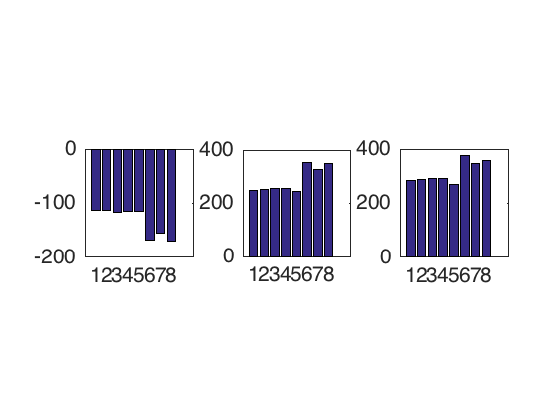

In [31]:
L   = -[L1,L2,L3,L4,L5,L6,L7,L8];
AIC = 2*[12,12,12,12,8,8,8,4] - 2*L;
BIC = - 2*L + [12,12,12,12,8,8,8,4]*log(size(X1,1));

subplot(1,3,1); bar(L),axis square
subplot(1,3,2); bar(AIC),axis square
subplot(1,3,3); bar(BIC),axis square

In this case we note that Models $1-5$ have comparable marginal likelihoods. Model $5$ has the best AIC and BIC scores. Objectively, then, there is some slight evidence for Model 5, suggesting that, for this gene, mock and hrpA are explained by a joint underlying noisy process (not differentially expressed), with DC3000 branching from that joint process. Let's take another look at the fit we get to the data using Model 5:

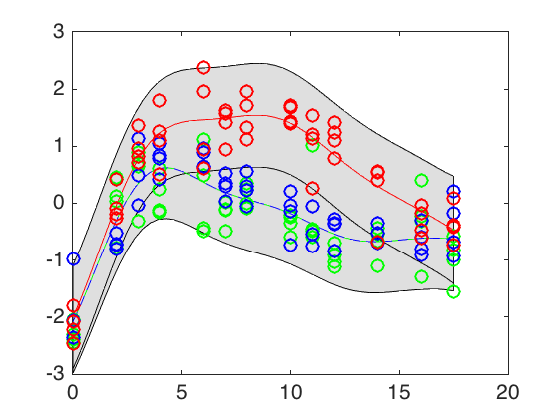

In [32]:
xpredloc = Xstar2(1:50,1);
f = [fmu5(1:50)+2*sqrt(ys25(1:50)); flipdim(fmu5(1:50)-2*sqrt(ys25(1:50)),1)];
fill([xpredloc; flipdim(xpredloc,1)], f, [7 7 7]/8);
hold on
f = [fmu5(101:150)+2*sqrt(ys25(101:150)); flipdim(fmu5(101:150)-2*sqrt(ys25(101:150)),1)];
fill([xpredloc; flipdim(xpredloc,1)], f, [7 7 7]/8);
plot(Xstar2(1:50,1),fmu5(1:50),'g-'),hold on
plot(Xstar2(1:50,1),fmu5(1:50),'b--'),hold on
plot(Xstar2(101:150,1),fmu5(101:150),'r-')
plot(repmat(tt,4,1)',expression_profile(1:4,:)','go')
plot(repmat(tt,4,1)',expression_profile(5:8,:)','bo')
plot(repmat(tt,4,1)',expression_profile(9:12,:)','ro')

It looks to be a reasonable fit. We can further dissect the behaviour of this gene by looking at the inferred branch time, which  is contained within the covariance hyperparameter:

In [33]:
disp(['Branch time is ' num2str(hyp_pN5.cov(1)) ' h.p.i'])

Branch time is 3.2646 h.p.i


The inferred branch time appears to be sensible as far as point estimators go, roughly in line with what's known about effector delivery, if maybe a little early. In this case it may be an advantagous to estimate the uncertainty in this timing. One way to do so would be to evaluate the marginal likelihood over a grid of branch times, keeping all other hyperparameters fixed, similarly to Yang *et al.* (2016):

In [34]:
prior.mean = {[]};  prior.cov  = {pcp1;[];[];[];[];[]}; prior.lik = {[]};

xgrid    = linspace(0,17.5,100);
im       = {@infPrior,@infExact,prior};                % inference method
par      = {'meanConst','covBranchingProcess_2A','likGauss',X2,Y1};

hyp = hyp_pN5;
for i = 1:100
    hyp.cov(1) = xgrid(i);
    [Likelihood(i) dL] = feval(@gp, hyp, im, par{:});         % optimise
end

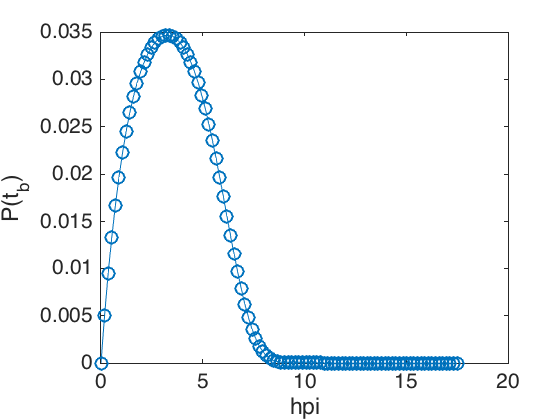

In [35]:
plot(xgrid,exp(-Likelihood)./sum(exp(-Likelihood)),'o-'),xlabel('hpi'),ylabel('P(t_b)')

Since, for our approach, the branch time is a hyperparameter of the covaraince function, we may instead sample this hyperparameter using hybrid Monte Carlo (in this case we will choose to keep the other hyperparameters fixed): 

In [38]:
%HMC parameteres
options     = foptions; % Default options vector.
options(1)  = 0;		% Switch on diagnostics.
options(5)  = 0;		% Use persistence
options(7)  = 3;		% Number of steps in trajectory.
options(14) = 1000;		% Number of Monte Carlo samples returned. 
options(15) = 100;		% Number of samples omitted at start of chain.
options(18) = 0.02;

%Fix all other hyperparameters but the branch time
pcp        = {@priorClamped};        
prior.mean = {pcp};  prior.cov  = {[];pcp;pcp;pcp;pcp;pcp}; prior.lik = {pcp};

im         = {@infPrior,@infExact,prior};
par        = {'meanConst','covBranchingProcess_2A','likGauss',X2,Y1, hyp_pN5};

%HMC
[samples, energies] = hmc2('gpfunc', unwrap(hyp_pN5), options, 'gpgrad', im, par{:});     

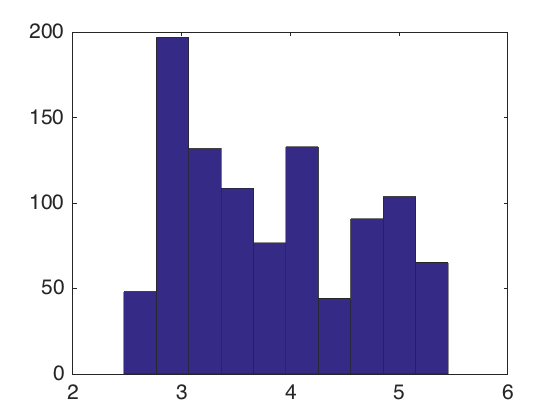

In [40]:
hist(samples(:,1))

The sampled branch times are roughly in line with the that seen using a grid evaluation of potential branch times, and comparable to the maximum likelihood estimators. Note that here we only used $1000$ samples in the HMC, typically we would use many more samples. 

#### Recombination Processes

If we take another look at the expression profile of our gene, it looks as though the control and DC3000 might recombine towards the end of the time series, suggesting that effector proteins delived by Pseudomonas might be surpressing the expression of the Arabidopsis gene back to control levels. Let's test this hypothesis by fitting a B/RGP and compare our fit to that we get using a Branching Process. More specifically, in order to make our models fully comparable, we will actually fit two B/RGPs. In the first model we assume DC3000 branches and then recombines with control. In the second model we will fix the recombination time to be at a time point far in the future, for example at $x=800$. For comparison we will also fit a joint GP to the union of time series. 

In [41]:
tt = [0,2,3,4,6,7,8,10,11,12,14,16,17.5];
X1 = [repmat(tt,1,8); ones(1,52),2*ones(1,52)]';

Xstar1 = [repmat(linspace(0,17.5,50),1,2);ones(1,50),2*ones(1,50)]';
pcp1   = {@priorGamma,2,2};    
pcp1p2 = {@priorGamma,4,2};    
pcp2_2 = {@priorClamped};  

%Observation data
Y2 = D1.data(gene_index,[1:52,2*52+1:3*52,52+1:2*52])'; %Mock, DC, hrpA
Y1 = Y2(1:2*52,:); %Take control and DC only

%Some parameters
l1 = log(3); l2 = log(3); lg = log(3); v1 = log(3); v2 = log(3); vg = log(std(Y1));

%Branching/recombination process
hyp.cov  = [18;1;3.5;1;l1;v1;l1;v1]; hyp.mean = mean(Y1(:,1)); hyp.lik  = 2;
prior.mean = {[]};  prior.cov  = {pcp1p2;[];pcp1;[];[];[];[];[]}; prior.lik = {[]};
im    = {@infPrior,@infExact,prior};                
par1a = {'meanConst','covBranchingRecombinationProcess_2C','likGauss',X1,Y1};
par1b = {'meanConst','covBranchingRecombinationProcess_2C','likGauss',X1,Y1,Xstar1};
hyp_pN1 = feval(@minimize, hyp, @gp, -1000, im, par1a{:});        
[L1 dL1] = gp(hyp_pN1, im, par1a{:});         % optimise
[ymu1 ys21 fmu1 fs21   ]= feval(@gp,hyp_pN1, im, par1b{:});

%Branching process (B/RGP the recombines at t=800, essentially at infinity)
hyp.cov  = [800;1; 4;1;l1;v1;l1;v1]; hyp.mean = mean(Y1(:,1)); hyp.lik  = 2;
prior.mean = {[]};  prior.cov  = {pcp2_2;pcp2_2;pcp1;[];[];[];[];[]}; prior.lik = {[]};
im = {@infPrior,@infExact,prior};                
par1a = {'meanConst','covBranchingRecombinationProcess_2C','likGauss',X1,Y1};
par1b = {'meanConst','covBranchingRecombinationProcess_2C','likGauss',X1,Y1,Xstar1};
hyp_pN3 = feval(@minimize, hyp, @gp, -1000, im, par1a{:});       
[L3 dL1] = gp(hyp_pN3, im, par1a{:});         
[ymu3 ys23 fmu3 fs23   ]= feval(@gp,hyp_pN3, im, par1b{:});

%Joint GP
hyp.cov = [lg;vg]; hyp.mean = mean(Y1(:,1)); hyp.lik = 2;
prior.mean = {[]};  prior.cov  = {[];[]}; prior.lik = {[]};
im = {@infPrior,@infExact,prior}; 
par1a = {'meanConst','covSEiso','likGauss',X1(:,1),Y1};
par1b = {'meanConst','covSEiso','likGauss',X1(:,1),Y1,Xstar1(:,1)};
hyp_pN7      = feval(@minimize, hyp, @gp, -1000, im, par1a{:});
[L7 dL7] = gp(hyp_pN7, im, par1a{:});
[ymu7 ys27 fmu7 fs27   ] = gp(hyp_pN7, im, par1b{:});

Let's plot the fitted B/RGP:

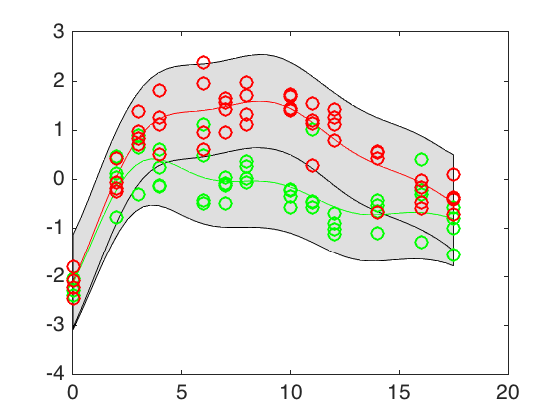

Branch time = 3.0824, recombination time =17.5007


In [44]:
xpredloc = Xstar1(1:50,1);
f = [fmu1(1:50)+2*sqrt(ys21(1:50)); flipdim(fmu1(1:50)-2*sqrt(ys21(1:50)),1)];
fill([xpredloc; flipdim(xpredloc,1)], f, [7 7 7]/8);
hold on
f = [fmu1(51:100)+2*sqrt(ys21(51:100)); flipdim(fmu1(51:100)-2*sqrt(ys21(51:100)),1)];
fill([xpredloc; flipdim(xpredloc,1)], f, [7 7 7]/8);
plot(Xstar1(1:50,1),fmu1(1:50),'g-'),hold on
plot(Xstar1(51:100,1),fmu1(51:100),'r-')
plot(repmat(tt,4,1)',expression_profile(1:4,:)','go')
plot(repmat(tt,4,1)',expression_profile(9:12,:)','ro')

disp(['Branch time = ' num2str(hyp_pN1.cov(3)) ', recombination time =' num2str(hyp_pN1.cov(1)) ])

Looks reasonable, but is the model fit any better than a standard Branching GP? Let's use the Marginal Likelihood, AIC and BIC scores to decide:

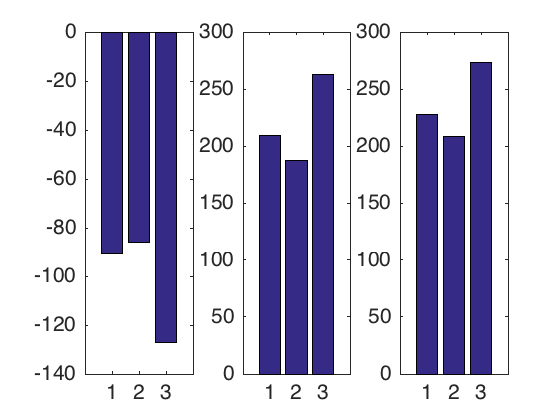

In [45]:
L = -[L1,L3,L7];
AIC = 2*[14,8,4] - 2*L;
BIC = - 2*L + [10,8,4]*log(size(X1,1));

subplot(1,3,1); bar(L)
subplot(1,3,2); bar(AIC)
subplot(1,3,3); bar(BIC)

Whilst the ML is similar, it seems as though the best fit is Model 2 (the branching process). So in this case, whilst there is evidence of branching, there is not enough evidence for us to conclude that Pseudomonas effectors are driving the expression profiles fully back to control levels.

The type of analysis outlined here was similar to the one we applied on a genome scale in Pefold *et al.* (2017). The only difference is that in Pefold *et al.* (2017) we ran the analysis for all $33,000+$ genes in the microarray, and used up to $30,000$ iterations in the linesearches to ensure good convergence.

### Section 4: Branching Processes with Partially Labelled Data

In the previous section we used B/RGPs to identify differential expression patterns from multiple time series data, using an Arabidopsis dataset as an illustrative example. Another application lies in identifying branching patterns of developmental processes using single cell RNA-seq measurments. For these datasets we do not necesarily have completely labelled data. For example, ...

In this section we demonstrate how we can infer the branc labels for a subset of data points via Gibbs sampling.

### Section 5: Branching Patterns of Primordial Germ Cells

### Section 6: Branching Patterns in Early Embryos

Let us now load in some labelled single cell data detailing early embryo development and the specification of three different cell types. We have labelled data here so move above Section 4. 

In [46]:
D1 = importdata('../AllProcesses_earlydev.csv');

Since this dataset is very large (containing thousands of measurements) we will subsample some cells. 

In [86]:
Type = D1.data(1,:); %Cell type
CapT = D1.data(2,:); %Capture time
Time = D1.data(3,:); %Pseudotime

Data.Y = log2(D1.data(4:end,:)+1)'; %Expression data

z = zeros(1,length(CapT));
z(find(Type==2))=ones;
z(find(Type==3))=2*ones;
z(find(Type==1))=3*ones;
z(find(z==0))=randi([1 3],1,length(find(z==0))); %Prior to branching

%We'll remove some data to make the GPs usable. Should really implement FITC.
remove_inds = []; uz = unique(Type); ut = unique(CapT);
for i = 1:length(ut)
    for j = 1:length(uz)
        ind = find(CapT==ut(i) & Type==uz(j));
        I(i,j) = length(ind);
            if isempty(ind)==0                        
                    MT(i,j) = mean(Time(ind));
                    remove_ind = ind(randperm(length(ind)));
                    remove_inds = [remove_inds,remove_ind(1:length(ind)-20)];
            end        
    end
end

%These are the training set indices
ind_train = setdiff(1:1:length(Time),[remove_inds]);

Type    = Type(ind_train);
CapT    = CapT(ind_train);
Time    = Time(ind_train);
Data.Y  = Data.Y(ind_train,:);
z       = z(ind_train);

Data.X = [Time',z'];
Xstar1 = [repmat(linspace(0,30,1000),1,4);ones(1,1000),2*ones(1,1000),3*ones(1,1000),4*ones(1,1000)]';

We can plot the expression pattern of these cells as a function of pseudotime:

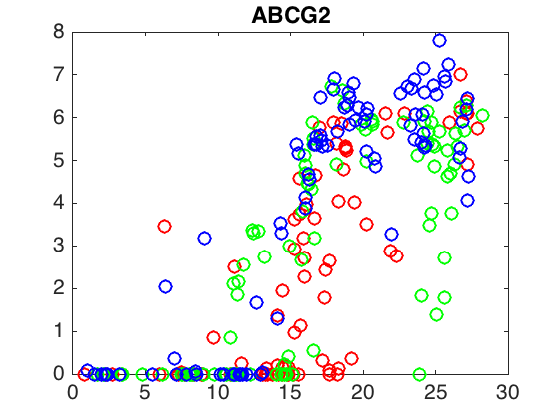

In [83]:
gene_ind = 13;

plot(Data.X(Data.X(:,2)==1,1),Data.Y(Data.X(:,2)==1,gene_ind),'ro'),hold on
plot(Data.X(Data.X(:,2)==2,1),Data.Y(Data.X(:,2)==2,gene_ind),'go')
plot(Data.X(Data.X(:,2)==3,1),Data.Y(Data.X(:,2)==3,gene_ind),'bo')
title([D1.textdata{6+gene_ind-1,1}])

Let's again try different permutations of branch structures. Define models here. 

In [69]:
hyp.cov  = [11;1.5;11;1.5;11;2;2;2;2;2;2;2;2;2]; hyp.mean = mean(Data.Y(:,i)); hyp.lik  = 2;

hyp_pN1 = feval(@minimize, hyp, @gp, -1000, 'infExact', 'meanConst', @covBranchingProcess_3C,'likGauss',Data.X,Data.Y(:,gene_ind));        
[L1 dL1] = feval(@gp,hyp_pN1, 'infExact', 'meanConst',@covBranchingProcess_3C,'likGauss',Data.X,Data.Y(:,gene_ind));         
[ymu1 ys21 fmu1 fs21   ]= feval(@gp,hyp_pN1, 'infExact', 'meanConst', @covBranchingProcess_3C,'likGauss',Data.X,Data.Y(:,gene_ind),Xstar1);

In [70]:
%1,2,3 -> 1,2,2
Data.X1 = Data.X;
Data.X1(find(Data.X1(:,2)==3),2)=2;

hyp_pN2 = feval(@minimize, hyp, @gp, -1000, 'infExact', 'meanConst', @covBranchingProcess_3C,'likGauss',Data.X1,Data.Y(:,gene_ind));         
[L2 dL2] = feval(@gp,hyp_pN2, 'infExact', 'meanConst',@covBranchingProcess_3C,'likGauss',Data.X1,Data.Y(:,gene_ind));  
[ymu2 ys22 fmu2 fs22   ]= feval(@gp,hyp_pN2, 'infExact', 'meanConst', @covBranchingProcess_3C,'likGauss',Data.X1,Data.Y(:,gene_ind),Xstar1);

In [71]:
%1,2,3 -> 1,1,2
Data.X2 = Data.X;
Data.X2(find(Data.X2(:,2)==2),2)=1;
Data.X2(find(Data.X2(:,2)==3),2)=2;

hyp_pN3 = feval(@minimize, hyp, @gp, -1000, 'infExact', 'meanConst', @covBranchingProcess_3C,'likGauss',Data.X2,Data.Y(:,gene_ind));       
[L3 dL3] = feval(@gp,hyp_pN3, 'infExact', 'meanConst',@covBranchingProcess_3C,'likGauss',Data.X2,Data.Y(:,gene_ind));        
[ymu3 ys23 fmu3 fs23   ]= feval(@gp,hyp_pN3, 'infExact', 'meanConst', @covBranchingProcess_3C,'likGauss',Data.X2,Data.Y(:,gene_ind),Xstar1);

In [72]:
%1,2,3 -> 1,2,1
Data.X3 = Data.X;
Data.X3(find(Data.X3(:,2)==3),2)=1;

hyp_pN4 = feval(@minimize, hyp, @gp, -1000, 'infExact', 'meanConst', @covBranchingProcess_3C,'likGauss',Data.X3,Data.Y(:,gene_ind));    
[L4 dL4] = feval(@gp,hyp_pN4, 'infExact', 'meanConst',@covBranchingProcess_3C,'likGauss',Data.X3,Data.Y(:,gene_ind));        
[ymu4 ys24 fmu4 fs24   ]= feval(@gp,hyp_pN4, 'infExact', 'meanConst', @covBranchingProcess_3C,'likGauss',Data.X3,Data.Y(:,gene_ind),Xstar1);

In [73]:
%1,2,3 -> 1,1,1
Data.X4 = Data.X;
Data.X4(find(Data.X4(:,2)==2),2)=1;
Data.X4(find(Data.X4(:,2)==2),3)=1;

hyp_pN5 = feval(@minimize, hyp, @gp, -1000, 'infExact', 'meanConst', @covBranchingProcess_3C,'likGauss',Data.X4,Data.Y(:,gene_ind));    
[L5 dL5] = feval(@gp,hyp_pN5, 'infExact', 'meanConst',@covBranchingProcess_3C,'likGauss',Data.X4,Data.Y(:,gene_ind));       
[ymu5 ys25 fmu5 fs25   ]= feval(@gp,hyp_pN5, 'infExact', 'meanConst', @covBranchingProcess_3C,'likGauss',Data.X4,Data.Y(:,gene_ind),Xstar1);

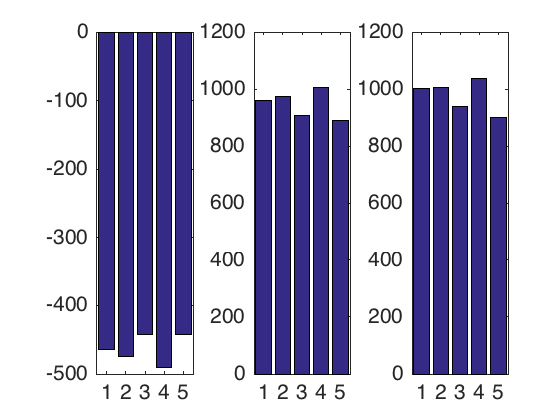

In [85]:
L = -[L1,L2,L3,L4,L5];
AIC = 2*[16,12,12,12,4] - 2*L;
BIC = - 2*L + [16,12,12,12,4]*log(size(X1,1));

subplot(1,3,1); bar(L),xlim([0.5 5.5])
subplot(1,3,2); bar(AIC),xlim([0.5 5.5])
subplot(1,3,3); bar(BIC),xlim([0.5 5.5])

We note that in this particular example we note Model 5 has the highest ML and best AIC/BIC scores, and is therefore the best model. This particular gene ABCG2, whilst highly dynamic over time, is not cell-type expressed. 

Note: find better example. 

### Section 7: Pseudotemporal Ordering of Branching 

Choose a simple, mimimal set of genes (maybe 4 or 5) and do PT on them to demonstrate things.